### Relax Data Science Challenge

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day
period, identify which factors predict future user adoption

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

### Actionable Insights

- Adopted users make up the minority of the population, only 0.18 of total users. There is a lot of room for growth.
- Users who are invited to an organization  as a guest, who opted into mailing list, and who create their account during working hours are most likely to be an adopted user. 

    Therefore, emphasize on inviting users to an organization as a guest. 


- Users who are enabled for marketing drip and users who signed up via website are less likely to be adopted user.  

    We should consult with our UX team to get more information regarding the website and marketing content.  

- The number of users increases from 2012 to 2013. The number drops the following year in 2014. The fraction of adopted user is steady between 2012 and 2013. The fraction is reduced in 2014. The highest number of users occur in May. The number of users are generally low between June and December. The highest fraction of adopted user occurs in June.

    More information (e.g., marketing and sales) is needed to understand this time-series trend. 


Below is the detail summary of my findings, as well as a description of the EDA, data preprocessing, and modeling appoaches. Refer to the **Appendix** for the details.

#### Summary of findings
- Adopted_users only make up 0.18 of total users.
- Gradient boosting model is selected for the analysis.
- Based on gradient boosting model creation_source is the most important factor for predicting future user adoption. 
- The second most important factor is opted_in_to_mailing_list, followed by whether the creation occurs during workinghours and enabled_for_marketing_drip.
- The highest number of users occur in 2013. The number drops the following year in 2014. The lowest number of users occur in 2012.
- The highest fraction of adopted user occur in 2012 and 2013. The fraction is reduced in 2014.
- The highest number of users occur in May. The number of users are generally low between June and December.
- The highest fraction of adopted user occurs in June

#### 1. EDA

- EDA suggest that org_id and invited_by_user_id are not significant factors. Therefore, they are omited in the model.
- The majority of the creation_source is ORG_INVITE
- The distribution for last_session_creation_time is skewed to the left.
- The majority of the users are not opted to the mailing list.
- The majority of the users disable for marketing drip.
- The majority of users are non-adopted user.


#### 2. Data preprocessing

- Only 42.4% (8823/207917) of the data is accounted for because the rest of the data have missing time stamp. The time stamp information is needed to determine if the user is an adopted user or not.
- The adopted_by_user_or_not column is generated and used as the dependent variable, y.
- The following independent factors are selected for the model:
    - workinghours in boolean
    - creation_source as labelencoder 
    - opted_in_to_mailing_list in boolean
    - enabled_for_marketing_drip in boolean
    - adopted_user_or_not in boolean

#### 3. Modeling

- Gradient boosting model is selected for the analysis.
- The factors that are considered include:
    - workinghours 
    - creation_source
    - last_session_creation_time
    - opted_in_to_mailing_list
    - enabled_for_marketing_drip
    - adopted_user_or_not
- The score of the training data is 0.92, whereas the score for the test data is 0.89.
- The AUROC is 0.88.

see the **Appendix** below for details.

***

### Appendix 

### 1. Familiarize with data

1.1. Inspect data

In [254]:
import pandas as pd

#import data 1
df1=pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])


In [255]:
df1.head() #check

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [256]:
#check for missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


- There are no missing values

1.2. Apply multi-indexing and analyze by user_id

In [257]:
#apply multi-indexing
df1.set_index(['user_id','time_stamp'], inplace=True)
df1.head(6) #check

visited
user_id time_stamp                  
1       2014-04-22 03:53:30        1
2       2013-11-15 03:45:04        1
        2013-11-29 03:45:04        1
        2013-12-09 03:45:04        1
        2013-12-25 03:45:04        1
        2013-12-31 03:45:04        1

In [258]:
#check number of unique user ids
df1.index.get_level_values(0).unique()

Int64Index([    1,     2,     3,     4,     5,     6,     7,    10,    11,
               13,
            ...
            11989, 11990, 11991, 11992, 11995, 11996, 11997, 11998, 11999,
            12000],
           dtype='int64', name='user_id', length=8823)

- Note that there are 8823 unique ids, but the last number is 12000. Therefore, some ids must be missing.


In [259]:
#check which ids are missing
#generate an array consisting of number than ranges from 1 to 12000
complete_id_list=[i for i in range(1,12000)]
user_id_list=df1.index.get_level_values(0).unique().tolist()

#get the difference between the complete ids and the user_id list
len(set(complete_id_list).difference(set(user_id_list)))


3177

In [260]:
#check
8823+3177

12000

- Indeed, the sum of the number of missing id and the number of user_id is 12000. 

1.3. Determine which user_id log in more than 3 times per week.

In [261]:
adopted_user_list=[] #create an empty list to store user_id that visit 3 or more times per week

#go through each user_id
for i in user_id_list:
    #resample data to weekly frequency
    df_temp=df1.ix[i].resample('W').sum()
    
    #if any of the visited column is greater or equal to 3 times a week, add to adopted_user_list 
    if (df_temp['visited']>=3.0).any():
        adopted_user_list.append(i)

In [262]:
print('There are %s user_ids that visit 3 or more times per week' %(len(adopted_user_list)))

There are 1445 user_ids that visit 3 or more times per week


In [263]:
print('The fraction of adopted user is: %.2f' %(1445/8223))

The fraction of adopted user is: 0.18


In [264]:
#check at random
import random
random_adopted_user_id=random.choice(adopted_user_list) #randomly select a number from adopted_user_id

df_random_adopted_user_id=df1.ix[random_adopted_user_id].resample('W').sum()
df_random_adopted_user_id.fillna(0, inplace=True) #replace NaN with 0s
df_random_adopted_user_id.head(10)

,visited
time_stamp,
2012-09-30,1.0
2012-10-07,0.0
2012-10-14,0.0
2012-10-21,0.0
2012-10-28,1.0
2012-11-04,2.0
2012-11-11,2.0
2012-11-18,3.0
2012-11-25,0.0


### 2. Exploratory Data Analysis

2.1. Pose some questions  

- Which user is most active?  
- How is the distribution of visits amongst the adopted users?  

In [265]:
#for each user id, calculate total number of visits divided by total number of weeks per user
#go through each user_id
#df_user_id_mean_per_week=pd.DataFrame() #create a DataFrame for storing the weekly avg no. of visits for each user id
df_user_id_mean_per_week=[]

for i in adopted_user_list:#user_id_list:
    #resample data to weekly frequency
    df_temp=df1.ix[i].resample('W').sum()
    df_temp.fillna(0, inplace=True) #replace NaN with 0s
    df_user_id_mean_per_week.append(df_temp.visited.mean())
    #df_user_id_mean_per_week[i]=df_temp.visited.mean() #calculate the mean and append to array. Ignore user_id
    
#get a DataFrame of user ID and average number of visits per week.

#Plot out the histogram of just number of visits per week. See if the distribution is skewed or not.

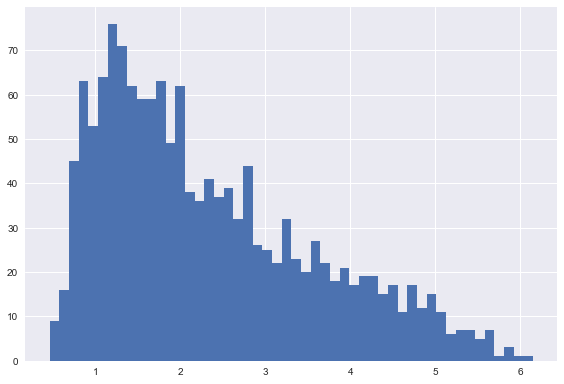

In [266]:
#df_user_id_mean_per_week.columns=['user_id','avg_visits_per_week']
#df_user_id_mean_per_week.T.head() #check

import matplotlib.pyplot as plt

plt.hist(df_user_id_mean_per_week, bins=50) 

plt.tight_layout()

plt.show()

- The distribution is skewed to the right. 
- There seems to be three distributions: the majority of users visit about once a week, some users visit about 2-3 times a week, and others visit about 4-5 times a week. 

***

### 3. Prepare data for modeling 

3.1. Import and inspect the second DataFrame

- Filter data only for user_ids that coincide with data 1

In [267]:
#import data 2
df2=pd.read_csv('takehome_users.csv', encoding='latin-1', parse_dates=['creation_time'])

#filter data 2 only for user_ids that coincide with data 1 
valid_user_id=list(df1.index.get_level_values(0).unique())

df2=df2[df2.object_id.isin(valid_user_id)]


- Add a column to indicate if the user is adopted user or not

In [268]:
df2['adopted_user_or_not']=df2.index.isin(adopted_user_list) #filter for just adopted_users and place results into a new column

df2.head() #check

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user_or_not
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [269]:
#check for missing values
df2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            4776 non-null float64
adopted_user_or_not           8823 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 766.8+ KB


- There are missing values within 'invited_by_user_id'


In [270]:
#count number of unique ids
len(df2.object_id.unique())

8823

- There are as many unique ids as the number of rows. Therefore, let's make the object_id column the index. 

In [271]:
df2=df2.set_index('object_id')

- Add a column to indicate if the user is adopted user or not. 

In [272]:
df2['adopted_user_or_not']=df2.index.isin(adopted_user_list) #filter for just adopted_users and place results into a new column
df2.head()#check

df2.head() #check

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user_or_not
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


- Some of the columns with data type object have categorical values (i.e., creation_source, enabled_for_marketing_drip and opted_in_to_mailing_list). So, let's change the data type to categorical.

In [319]:
#change datatype for columns accordingly

from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
df2.creation_source=labelencoder_X.fit_transform(df2.creation_source)
#df2.creation_source #check


In [274]:
#org_id
df2.org_id=df2.org_id.astype('category');

#enabled_for_marketing_drip
df2.enabled_for_marketing_drip=df2.enabled_for_marketing_drip.astype('bool'); 

#opted_in_to_mailing_list
df2.opted_in_to_mailing_list=df2.opted_in_to_mailing_list.astype('bool'); 

#org_id
df2.org_id=df2.org_id.astype('category'); 

#check
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null int64
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      8823 non-null bool
enabled_for_marketing_drip    8823 non-null bool
org_id                        8823 non-null category
invited_by_user_id            4776 non-null float64
adopted_user_or_not           8823 non-null bool
dtypes: bool(3), category(1), datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 528.8+ KB


In [275]:
#check if all names are distinct
print('Shape of pandas DataFrame:', df2.shape[0])
print('Number of unique names:', len(set(df2.name)))

Shape of pandas DataFrame: 8823
Number of unique names: 8453


In [276]:
#check if email addresses are distinct
print('Shape of pandas DataFrame:', df2.shape[0])
print('Number of unique emails:', len(set(df2.email)))

Shape of pandas DataFrame: 8823
Number of unique emails: 8810


- Some users may have multiple accounts.
- Some users may have the same names, but they are actually different people.

3.2. Visualize data and identify trends

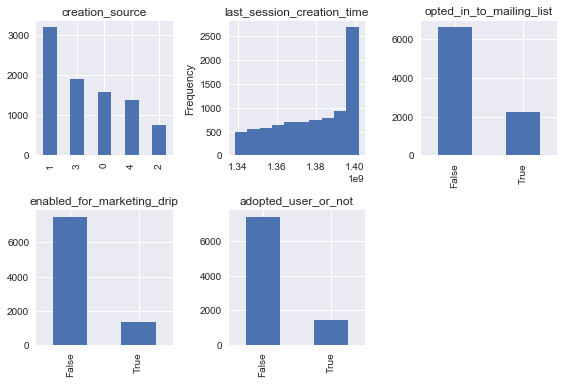

In [277]:
plt.subplot(2,3,1)
df2.creation_source.value_counts().plot(kind='bar')
plt.title('creation_source')

plt.subplot(2,3,2)
df2.last_session_creation_time.plot(kind='hist')
plt.title('last_session_creation_time')

plt.subplot(2,3,3)
df2.opted_in_to_mailing_list.value_counts().plot(kind='bar')
plt.title('opted_in_to_mailing_list')

plt.subplot(2,3,4)
df2.enabled_for_marketing_drip.value_counts().plot(kind='bar')
plt.title('enabled_for_marketing_drip')

plt.subplot(2,3,5)
df2.adopted_user_or_not.value_counts().plot(kind='bar')
plt.title('adopted_user_or_not')


plt.tight_layout()
plt.show()

- The majority of the creation_source is ORG_INVITE
- The distribution for last_session_creation_time is skewed to the left.
- The majority of the users are not opted to the mailing list.
- The majority of the users disable for marketing drip.
- The majority of users are non-adopted user.


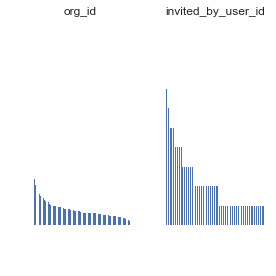

In [278]:
plt.subplot(1,2,1)
df2.org_id.value_counts().plot(kind='bar', figsize=(4,4))
plt.title('org_id')
plt.axis('off') #turn off axis

plt.subplot(1,2,2)
df2.invited_by_user_id.value_counts().plot(kind='bar', figsize=(4,4))
plt.title('invited_by_user_id')
plt.axis('off') #turn off axis

plt.tight_layout()
plt.show()


- The distribution of org_id is skewed.
- The distribution of invited_by_user_id is skewed.

3.3. org_id

Review the top 20 counts 

In [279]:
print('The top 20 counts of number of users in a single invited_by_user_id', list(df2.org_id.value_counts())[:20]) #show the top 20

The top 20 counts of number of users in a single invited_by_user_id [228, 172, 150, 125, 122, 102, 91, 88, 87, 68, 67, 66, 58, 57, 56, 54, 50, 50, 47, 47]


In [280]:
print('Number of unique org_id:', len(df2.org_id.unique()))

Number of unique org_id: 417


In [281]:
print('Total number of users with assigned org_id:', len(df2.org_id))

Total number of users with assigned org_id: 8823


- The maximum number of users per org_id is 228. 228 out of 8823 is a small fraction.
- Therefore, it is not worthwhile to seek for correlation between org_id with adopted users. 
- Moreover, there is a large number of the unique org_id (i.e., 417). 

3.4. Invited_by_user_id

Review the top 20 counts 

In [282]:
print('The top 20 counts of number of users in a single invited_by_user_id', list(df2.invited_by_user_id.value_counts())[:20]) #show the top 20

The top 20 counts of number of users in a single invited_by_user_id [10, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7]


In [283]:
print('Number of unique invited_by_user_id:', len(df2.invited_by_user_id.unique()))

Number of unique invited_by_user_id: 2230


In [284]:
print('Total number of users with assigned invited_by_user_id:', len(df2.invited_by_user_id))

Total number of users with assigned invited_by_user_id: 8823


- The maximum number of users per invited_by_user_id is 10. 10 out of 8823 is a very small fraction.
- Therefore, it is not worthwhile to seek for correlation between invited_by_user_id with adopted users. 
- Moreover, there is a large number of the unique invited_by_user_id (i.e., 2230). 

### 4. Carry out modeling

4.1. Prepare data


In [285]:
# Import machine learning modules
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, partial_dependence
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score


In [286]:
df2.head() #review data

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user_or_not
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,0,1.398139e+09,True,False,11,10803.0,False
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,1.396238e+09,False,False,1,316.0,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,1.363735e+09,False,False,94,1525.0,False
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,1.369210e+09,False,False,1,5151.0,False
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,1.358850e+09,False,False,193,5240.0,False


4.2. Case I: Fit all parameters, but creation_time, name, and email. Drop all rows with NaN 

- Using an ensemble method

In [287]:
df3=df2.iloc[:,3:] #create a new DataFrame from df2, but skip creation_time, name, and email

In [288]:
#drop last_session_creation_time, org_id, and invited_by_user_id
df3=df3.drop(['last_session_creation_time','org_id','invited_by_user_id'], axis=1)
df3.head() #check

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user_or_not
object_id,,,,
1,0,True,False,False
2,1,False,False,True
3,1,False,False,False
4,0,False,False,False
5,0,False,False,False


Check for null entries

In [289]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 4 columns):
creation_source               8823 non-null int64
opted_in_to_mailing_list      8823 non-null bool
enabled_for_marketing_drip    8823 non-null bool
adopted_user_or_not           8823 non-null bool
dtypes: bool(3), int64(1)
memory usage: 163.7 KB


- Null entries are seen for 'invited_by_user_id' and 'last_session_creation_time' columns

In [290]:
#delete null entries
df3=df3.dropna()
df3.info() #check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 4 columns):
creation_source               8823 non-null int64
opted_in_to_mailing_list      8823 non-null bool
enabled_for_marketing_drip    8823 non-null bool
adopted_user_or_not           8823 non-null bool
dtypes: bool(3), int64(1)
memory usage: 163.7 KB


In [291]:
print(list(df2.creation_source.unique()))
print(list(df3.creation_source.unique()))

[0, 1, 3, 2, 4]
[0, 1, 3, 2, 4]


- Note that by eliminating NaN entries, all four categories of creation_source remain.

In [292]:
#check the column fields
df3.columns

Index(['creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'adopted_user_or_not'],
      dtype='object')

In [293]:
#set X and y datasets

X3=df3.iloc[:,:-1]
y3=df3.iloc[:,-1]

In [294]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3,test_size=0.2,random_state=123)

In [295]:
gbc3=GradientBoostingClassifier()
gbc3.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [296]:
gbc3.score(X_test,y_test)

0.83739376770538243

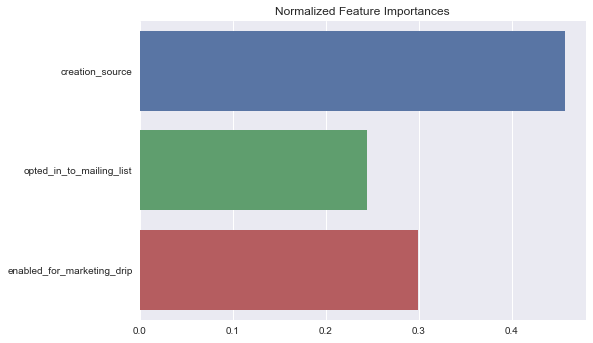

In [297]:
import seaborn as sns
# Plot feature importances
plt.title('Normalized Feature Importances')
sns.barplot(y=X3.columns, x=gbc3.feature_importances_)
plt.show()

In [298]:
#df3.creation_source.value_counts().plot(kind='bar', figsize=(4,4))
df3.creation_source
plt.show()

In [299]:
# Get class probability predictions on test set
pred = gbc3.predict_proba(X_test)

# Only keep the positive class
pred = [p[1] for p in pred]

# Display AUROC
roc_auc_score(y_test, pred)

0.51669197003201417

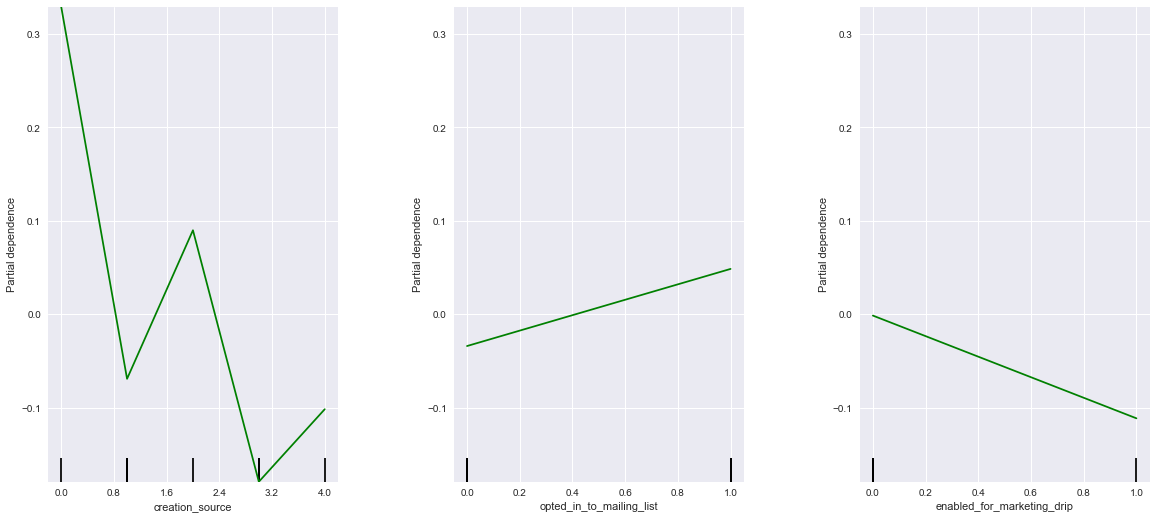

In [300]:
# Partial dependence plots
from sklearn.ensemble import GradientBoostingClassifier, partial_dependence
partial_dependence.plot_partial_dependence(gbc3,X=X_train,features=range(len(X3.columns)),feature_names=X3.columns,
                                           figsize=(18,12))
plt.show()

4.3. Case II: Fit all parameters, but name and email. Take into account whether the creation time is during working hours or not. Drop all rows with NaN 

- Process time period

In [301]:
#https://stackoverflow.com/questions/35595710/splitting-timestamp-column-into-seperate-date-and-time-columns?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
#year, month, day, time
df4a=pd.DataFrame()
df4a['Year'] = df2['creation_time'].dt.year
df4a['Month'] = df2['creation_time'].dt.month
df4a['Day'] = df2['creation_time'].dt.day
#df3['new_time'] = [d.time() for d in df2['creation_time']]

#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.dayofweek.html
df4a['dayofweek']=df2['creation_time'].dt.dayofweek #get the day of the week
df4a['hour']=df2['creation_time'].dt.hour
df4a['minute']=df2['creation_time'].dt.minute

df4a.head() #check

,Year,Month,Day,dayofweek,hour,minute
object_id,,,,,,
1,2014,4,22,1,3,53
2,2013,11,15,4,3,45
3,2013,3,19,1,23,14
4,2013,5,21,1,8,9
5,2013,1,17,3,10,14


In [302]:
#https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
#need to make a function that can be applied to two columns

#Based on the day of the week and the hour of the day, determine if it is during working hour or not.
def workinghours(dayofweek, hour):
    if (dayofweek != (5&6))& hour>=9 & hour<=17:
        return True
    else:
        return False
            

In [303]:
#df3['period'] = df.apply(period, axis=1)

df4a['workinghours'] = list(map(workinghours,df4a['dayofweek'],df4a['hour']))

df4a.head()

,Year,Month,Day,dayofweek,hour,minute,workinghours
object_id,,,,,,,
1,2014,4,22,1,3,53,True
2,2013,11,15,4,3,45,False
3,2013,3,19,1,23,14,True
4,2013,5,21,1,8,9,False
5,2013,1,17,3,10,14,False


- Combine selected time information (year, month, and workinghours) with the rest of the data

In [304]:
df4b=pd.concat([df4a.iloc[:,[0,1,6]],df2.iloc[:,3:]],axis=1)
df4b.head() #check

,Year,Month,workinghours,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user_or_not
object_id,,,,,,,,,,
1,2014,4,True,0,1.398139e+09,True,False,11,10803.0,False
2,2013,11,False,1,1.396238e+09,False,False,1,316.0,True
3,2013,3,True,1,1.363735e+09,False,False,94,1525.0,False
4,2013,5,False,0,1.369210e+09,False,False,1,5151.0,False
5,2013,1,False,0,1.358850e+09,False,False,193,5240.0,False


In [305]:
#drop org_id and invited_by_user_id
df4b=df4b.drop(['last_session_creation_time','org_id','invited_by_user_id'],axis=1)
df4b.head() #check

,Year,Month,workinghours,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user_or_not
object_id,,,,,,,
1,2014,4,True,0,True,False,False
2,2013,11,False,1,False,False,True
3,2013,3,True,1,False,False,False
4,2013,5,False,0,False,False,False
5,2013,1,False,0,False,False,False


In [306]:
#remove NaNs
df4b.dropna()
df4b.info() #check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 7 columns):
Year                          8823 non-null int64
Month                         8823 non-null int64
workinghours                  8823 non-null bool
creation_source               8823 non-null int64
opted_in_to_mailing_list      8823 non-null bool
enabled_for_marketing_drip    8823 non-null bool
adopted_user_or_not           8823 non-null bool
dtypes: bool(4), int64(3)
memory usage: 310.2 KB


- There are nulls

In [307]:
from sklearn.preprocessing import LabelBinarizer

labelbinarizer_X4=LabelBinarizer()
df4b.workinghours=labelbinarizer_X4.fit_transform(df4b.workinghours)

In [308]:
df4b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 7 columns):
Year                          8823 non-null int64
Month                         8823 non-null int64
workinghours                  8823 non-null int32
creation_source               8823 non-null int64
opted_in_to_mailing_list      8823 non-null bool
enabled_for_marketing_drip    8823 non-null bool
adopted_user_or_not           8823 non-null bool
dtypes: bool(3), int32(1), int64(3)
memory usage: 336.0 KB


- Split data into X and y

In [309]:
X4=df4b.iloc[:,2:-1]
y4=df4b.iloc[:,-1]

In [310]:
X4.info() #check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 4 columns):
workinghours                  8823 non-null int32
creation_source               8823 non-null int64
opted_in_to_mailing_list      8823 non-null bool
enabled_for_marketing_drip    8823 non-null bool
dtypes: bool(2), int32(1), int64(1)
memory usage: 189.6 KB


In [311]:
#split into test and train sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4,test_size=0.2,random_state=123)

In [312]:
gbc4=GradientBoostingClassifier()
gbc4.fit(X4_train,y4_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [313]:
gbc4.score(X4_train,y4_train)

0.83593085860017002

In [314]:
gbc4.score(X4_test,y4_test)

0.83739376770538243

In [315]:
# Get class probability predictions on test set
pred4 = gbc4.predict_proba(X4_test)

# Only keep the positive class
pred4 = [p[1] for p in pred4]

# Display AUROC
roc_auc_score(y4_test, pred4)

0.52508569354009793

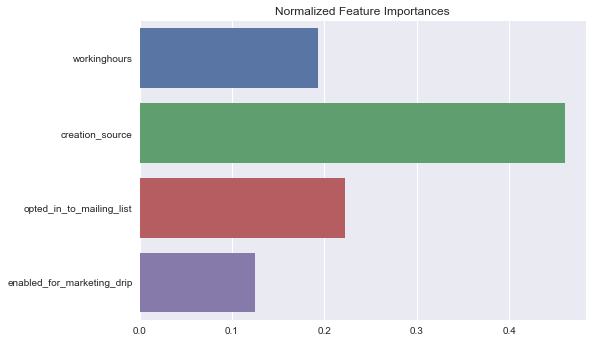

In [316]:
import seaborn as sns
# Plot feature importances
plt.title('Normalized Feature Importances')
sns.barplot(y=X4.columns, x=gbc4.feature_importances_)
plt.show()

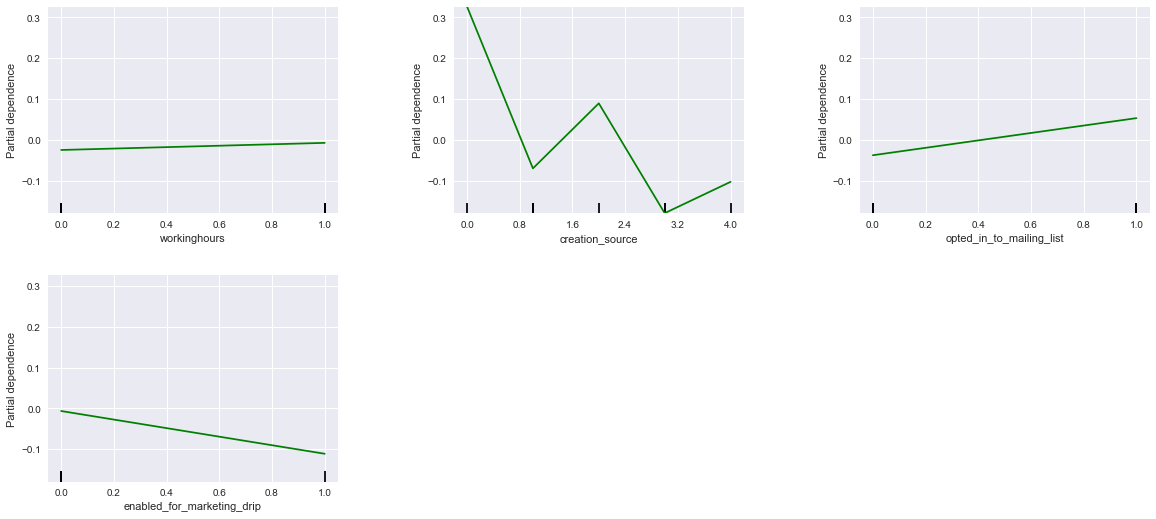

In [317]:
# Partial dependence plots

partial_dependence.plot_partial_dependence(gbc4,X=X4_train,features=range(len(X4.columns)),feature_names=X4.columns,
                                           figsize=(18,12))
plt.show()

- There is a correlation between adopted user and all four factors. 
- Creation source shows the strongest correlation with 0 being the highest (GUEST_INVITE) and 3 being the lowest (SIGNUP). 
- The correlation is positive for workinghours and for opted_in_to_mailing list.
- The correlation is negative for enabled_for marketing_drip.


4.4. What about fraction of adopted user by year?


In [321]:
df4b.head()


,Year,Month,workinghours,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user_or_not
object_id,,,,,,,
1,2014,4,1,0,True,False,False
2,2013,11,0,1,False,False,True
3,2013,3,1,1,False,False,False
4,2013,5,0,0,False,False,False
5,2013,1,0,0,False,False,False


In [322]:
#Should plot by year the value counts
#df4b.workinghours.value_counts().groupby('Year')

#plot by year 
#https://stackoverflow.com/questions/23415500/pandas-plotting-a-stacked-bar-chart?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

#count number of True and False
df_stacked_bar1a = df4b.groupby(['Year'])['adopted_user_or_not'].value_counts()
#unstack data
df_stacked_bar1a=df_stacked_bar1a.unstack()
df_stacked_bar1a #check

adopted_user_or_not,False,True
Year,,
2012,1615,415
2013,3361,807
2014,2402,223


In [323]:
#normalize rows
df_stacked_bar1b=df_stacked_bar1a
#calculate the sum of True and False
df_stacked_bar1b['sum']=df_stacked_bar1b.sum(axis=1)
#caculate the fraction
df_stacked_bar1b = df_stacked_bar1b.iloc[:,:2].div(df_stacked_bar1b["sum"], axis=0)
#check
df_stacked_bar1b.head() #check

adopted_user_or_not,False,True
Year,,
2012,0.795567,0.204433
2013,0.806382,0.193618
2014,0.915048,0.084952


In [324]:
#https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
#plot by month and normalize

#count number of True and False
df_stacked_bar2 = df4b.groupby(['Month'])['adopted_user_or_not'].value_counts()
#unstack data
df_stacked_bar2a=df_stacked_bar2.unstack()
df_stacked_bar2a.head() #check

adopted_user_or_not,False,True
Month,,
1,625,131
2,595,117
3,749,126
4,778,89
5,978,68


In [325]:
#normalize rows
#calculate the sum of True and False
df_stacked_bar2b=df_stacked_bar2a
df_stacked_bar2b['sum']=df_stacked_bar2a.sum(axis=1)
#caculate the fraction
df_stacked_bar2b = df_stacked_bar2b.iloc[:,:2].div(df_stacked_bar2b["sum"], axis=0)
#check
df_stacked_bar2b.head() #check

adopted_user_or_not,False,True
Month,,
1,0.826720,0.173280
2,0.835674,0.164326
3,0.856000,0.144000
4,0.897347,0.102653
5,0.934990,0.065010


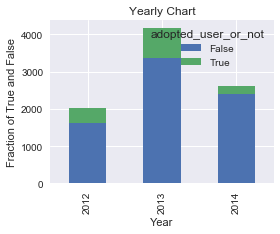

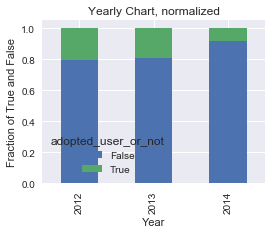

In [326]:
df_stacked_bar1a.iloc[:,:2].plot(kind='bar', stacked=True, figsize=(4,3))
plt.ylabel('Fraction of True and False')
plt.title('Yearly Chart')

df_stacked_bar1b.plot(kind='bar', stacked=True, figsize=(4,3))
plt.ylabel('Fraction of True and False')
plt.title('Yearly Chart, normalized')

plt.show()

- The highest number of users occur in 2013. The number drops the following year in 2014. The lowest number of users occur in 2012.
- The fraction of adopted user is steady between 2012 and 2013. The fraction is reduced in 2014.

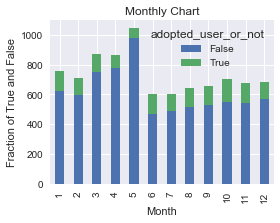

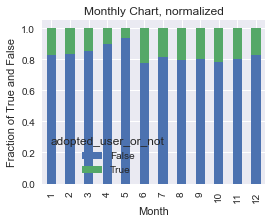

In [327]:
df_stacked_bar2a.iloc[:,:2].plot(kind='bar', stacked=True, figsize=(4,3))
plt.ylabel('Fraction of True and False')
plt.title('Monthly Chart')

df_stacked_bar2b.plot(kind='bar', stacked=True, figsize=(4,3))
plt.ylabel('Fraction of True and False')
plt.title('Monthly Chart, normalized')

plt.show()

- The highest number of users occur in May. The number of users are generally low between June and December.
- The highest fraction of adopted user occurs in June

### 5. Terminologies

● name: the user's name  
● object_id: the user's id  
● email: email address  
● creation_source: how their account was created. This takes on one of 5 values:  

    ○ PERSONAL_PROJECTS: invited to join another user's personal workspace  
    
    ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)  
    
    ○ ORG_INVITE: invited to an organization (as a full member)  
    
    ○ SIGNUP: signed up via the website  
    
    ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)   
    
● creation_time: when they created their account  
● last_session_creation_time: unix timestamp of last login  
● opted_in_to_mailing_list: whether they have opted into receiving marketing emails  
● enabled_for_marketing_drip: whether they are on the regular marketing email drip  
● org_id: the organization (group of users) they belong to  
● invited_by_user_id: which user invited them to join (if applicable). 